In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

# Load S&P 500 ticker symbols
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = sp500['Symbol'].to_list()

# Download historical price data
data = yf.download(tickers, start='2015-01-01', end='2023-10-01')['Adj Close']
data = data.tz_localize(None)
# Forward-fill and drop any remaining NaNs
data = data.ffill().dropna(axis=1)


[*********************100%***********************]  503 of 503 completed

6 Failed downloads:
['GEV', 'SOLV', 'VLTO', 'SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2023-10-01) (Yahoo error = "Data doesn\'t exist for startDate = 1420088400, endDate = 1696132800")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2023-10-01)')


In [2]:
# Calculate monthly returns
monthly_prices = data.resample('M').last()
monthly_returns = monthly_prices.pct_change()

# Calculate 12-month momentum excluding the last month
momentum_signal = monthly_returns.rolling(window=12).apply(lambda x: (1 + x[:-1]).prod() - 1)


C:\Users\sandr\AppData\Local\Temp\ipykernel_3728\652519311.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = data.resample('M').last()


In [3]:
# Placeholder for the fundamental data
# In practice, you'd retrieve this data from a financial database
fundamentals = pd.DataFrame({
    'Ticker': tickers,
    'Price_to_Book': [2.5] * len(tickers)  # Replace with actual data
}).set_index('Ticker')

# Calculate the inverse Price-to-Book ratio
value_signal = 1 / fundamentals['Price_to_Book']


In [4]:
# Normalize signals
momentum_norm = momentum_signal.div(momentum_signal.abs().sum(axis=1), axis=0)
value_norm = value_signal / value_signal.abs().sum()

# Combine signals with equal weighting
combined_signal = momentum_norm.mul(0.5).add(value_norm.mul(0.5))


In [5]:
# For each rebalancing date, calculate weights
rebalance_dates = monthly_returns.index[12::3]  # Quarterly rebalancing
portfolio_weights = {}

for date in rebalance_dates:
    signal = combined_signal.loc[date]
    # Rank stocks based on signal
    ranked = signal.rank(ascending=False)
    # Select top N stocks
    top_n = ranked[ranked <= 50].index
    weights = pd.Series(1/50, index=top_n)
    portfolio_weights[date] = weights


In [6]:
portfolio_returns = pd.Series(dtype=float)

for i in range(len(rebalance_dates)-1):
    start_date = rebalance_dates[i]
    end_date = rebalance_dates[i+1]
    weights = portfolio_weights[start_date]
    # Get the returns for the period
    period_returns = monthly_returns.loc[start_date:end_date, weights.index]
    # Calculate portfolio returns
    returns = period_returns.mul(weights, axis=1).sum(axis=1)
    if portfolio_returns.empty:
        portfolio_returns = returns
    else:
        portfolio_returns = pd.concat([portfolio_returns, returns])




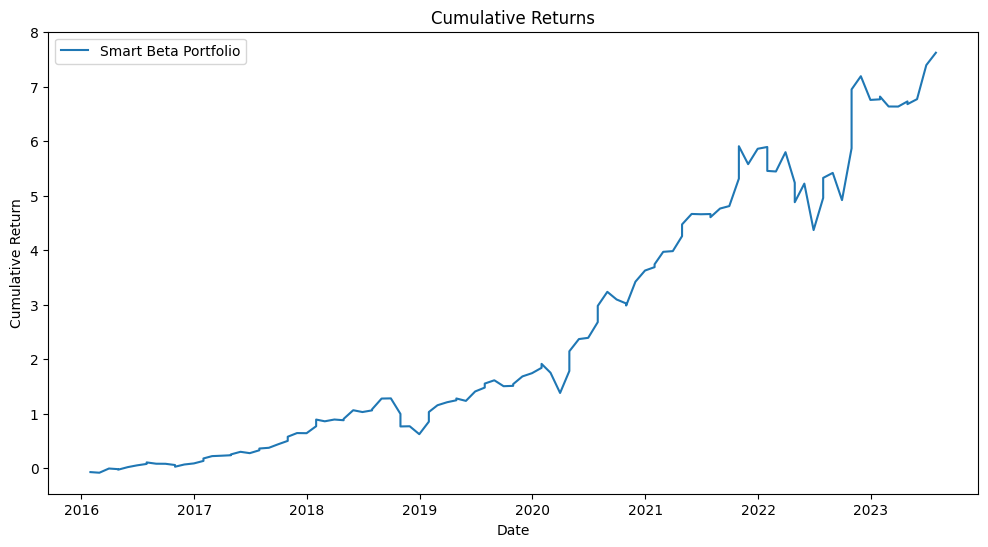

Annual Return: 13276.76%
Annual Volatility: 87.87%
Sharpe Ratio: 151.10


In [7]:
import matplotlib.pyplot as plt

# Cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='Smart Beta Portfolio')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Performance metrics
def calculate_performance_metrics(returns):
    annual_return = ((1 + returns.mean()) ** 252) - 1
    annual_volatility = returns.std() * (252 ** 0.5)
    sharpe_ratio = annual_return / annual_volatility
    return annual_return, annual_volatility, sharpe_ratio

annual_return, annual_volatility, sharpe_ratio = calculate_performance_metrics(portfolio_returns)

print(f'Annual Return: {annual_return:.2%}')
print(f'Annual Volatility: {annual_volatility:.2%}')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')



In [8]:
# Implement threshold rebalancing (e.g., 5% threshold)
threshold = 0.05

transaction_cost = 0.0005  # 0.05% per trade
total_costs = 0

for i in range(len(rebalance_dates)-1):
    start_date = rebalance_dates[i]
    end_date = rebalance_dates[i+1]
    weights = portfolio_weights[start_date]
    costs = 0
    if i > 0:
        prev_weights = portfolio_weights[rebalance_dates[i-1]]
        # Calculate turnover
        turnover = (weights - prev_weights).abs().sum()
        costs = turnover * transaction_cost
        total_costs += costs
    # Adjust returns for transaction costs
    period_returns = monthly_returns.loc[start_date:end_date, weights.index]
    returns = period_returns.mul(weights, axis=1).sum(axis=1) - costs
    portfolio_returns.update(returns)


In [9]:

def calculate_performance_metrics(returns):
    # Annualized return
    cumulative_return = (1 + returns).prod() - 1
    num_years = (returns.index[-1] - returns.index[0]).days / 365.25
    annual_return = (1 + cumulative_return) ** (1 / num_years) - 1
    # Annualized volatility
    annual_volatility = returns.std() * np.sqrt(252)
    # Sharpe Ratio (Assuming risk-free rate is zero)
    sharpe_ratio = annual_return / annual_volatility
    return annual_return, annual_volatility, sharpe_ratio

annual_return, annual_volatility, sharpe_ratio = calculate_performance_metrics(portfolio_returns)

print(f'Annual Return: {annual_return:.2%}')
print(f'Annual Volatility: {annual_volatility:.2%}')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')


Annual Return: 29.95%
Annual Volatility: 84.30%
Sharpe Ratio: 0.36


In [10]:
def max_drawdown(cumulative_returns):
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_dd = drawdown.min()
    return max_dd

max_dd = max_drawdown(cumulative_returns)
print(f'Maximum Drawdown: {max_dd:.2%}')


Maximum Drawdown: -72.58%


In [11]:
# Calculate portfolio beta against a benchmark
benchmark_returns = yf.download('^GSPC', start='2015-01-01', end='2023-10-01')['Adj Close'].pct_change()
benchmark_returns = benchmark_returns.tz_localize(None)
aligned_returns = portfolio_returns.align(benchmark_returns, join='inner')[0]
covariance = aligned_returns.cov(benchmark_returns)
beta = covariance / benchmark_returns.var()
print(f'Portfolio Beta: {beta:.2f}')


[*********************100%***********************]  1 of 1 completed

Portfolio Beta: -0.34


In [12]:
from scipy.optimize import minimize


def portfolio_optimization(expected_returns, cov_matrix):
    num_assets = len(expected_returns)
    args = (expected_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    def portfolio_variance(weights, expected_returns, cov_matrix):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    result = minimize(portfolio_variance, num_assets*[1./num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Calculate expected returns and covariance matrix
expected_returns = monthly_returns.mean()
cov_matrix = monthly_returns.cov()

optimal_weights = portfolio_optimization(expected_returns, cov_matrix)

print(optimal_weights)


[0.00000000e+00 0.00000000e+00 5.83528670e-03 9.30237715e-19
 0.00000000e+00 2.10733678e-18 5.74786484e-18 5.65886022e-18
 0.00000000e+00 6.46469017e-19 0.00000000e+00 1.98706262e-03
 5.02769478e-18 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.13483280e-02 7.84617861e-20 6.37117599e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.38425247e-18 0.00000000e+00
 5.98496835e-18 2.89079429e-19 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.87920776e-18 4.28487678e-18
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.43872603e-18
 2.00366289e-18 1.78385974e-18 1.01046729e-18 1.67646140e-18
 0.00000000e+00 1.56709586e-02 5.73578334e-19 3.09527980e-18
 4.57230914e-19 0.00000000e+00 1.74276525e-03 0.00000000e+00
 0.00000000e+00 1.45401108e-18 2.50833512e-18 0.00000000e+00
 3.21101034e-04 7.28146800e-02 3.00113409e-18 4.27879955e-19
 0.00000000e+00 3.51563610e-18 0.00000000e+00 0.00000000e+00
 1.07979030e-18 0.000000

## 5 factors model

### Introduction to the Five Factors
Before diving into the code, let's briefly understand each factor:
1. Value: Stocks that are undervalued relative to their fundamentals (e.g., low P/B ratios).
2. Size: Smaller companies tend to outperform larger ones (small-cap effect).
3. Low Volatility: Stocks with lower historical volatility tend to offer better risk-adjusted returns.
4. Profitability: Companies with higher profitability ratios outperform less profitable ones.
5. Momentum: Stocks with strong past performance tend to continue performing well in the short term.

### Data Acquisition
We'll need both price data and fundamental data. For price data, we'll continue using yfinance. For fundamental data, we'll use yfinance for basic metrics and supplement with other sources if necessary.

In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

# Load S&P 500 ticker symbols
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = sp500['Symbol'].to_list()

# Remove tickers with dots (e.g., BRK.B) which yfinance may not handle well
tickers = [ticker.replace('.', '-') for ticker in tickers]

# Download historical price data
data = yf.download(tickers, start='2015-01-01', end='2023-10-01', progress=False)['Adj Close']
data = data.tz_localize(None)


4 Failed downloads:
['GEV', 'SOLV', 'VLTO', 'SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2023-10-01) (Yahoo error = "Data doesn\'t exist for startDate = 1420088400, endDate = 1696132800")')


### Cleaning the Data

In [14]:
# Forward-fill and drop any remaining NaNs
data = data.ffill().dropna(axis=1)

### Calculating Factor Signals
We'll calculate each factor individually.

**Value Factor**:

Metric: Inverse of Price-to-Book (P/B) ratio.

In [15]:
# Retrieve P/B ratios using yfinance
pb_ratios = {}
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        pb = stock.info['priceToBook']
        pb_ratios[ticker] = pb
    except:
        pb_ratios[ticker] = np.nan

pb_series = pd.Series(pb_ratios)
# Inverse P/B ratio (Value factor)
value_signal = 1 / pb_series


**Size Factor**:

Metric: Market capitalization.

In [16]:
# Retrieve market capitalizations
market_caps = {}
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        mc = stock.info['marketCap']
        market_caps[ticker] = mc
    except:
        market_caps[ticker] = np.nan

market_caps_series = pd.Series(market_caps)
# Inverse market cap (Size factor: smaller companies get higher scores)
size_signal = 1 / market_caps_series


**Low Volatility Factor**:

Metric: Historical volatility over the past year.

In [17]:
# Calculate daily returns
daily_returns = data.pct_change()

# Calculate annualized volatility over the past year
volatility_signal = daily_returns.rolling(window=252).std() * np.sqrt(252)
# Use the latest available volatility
latest_volatility = volatility_signal.iloc[-1]
# Inverse volatility (Low volatility factor)
low_volatility_signal = 1 / latest_volatility

**Profitability Factor**:

Metric: Return on Equity (ROE) or Return on Assets (ROA).

In [18]:
# Retrieve ROE using yfinance
roe_ratios = {}
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        roe = stock.info['returnOnEquity']
        roe_ratios[ticker] = roe
    except:
        roe_ratios[ticker] = np.nan

profitability_signal = pd.Series(roe_ratios)


**Momentum Factor**:

Metric: 12-month past return excluding the most recent month.

In [19]:
# Calculate monthly returns
monthly_prices = data.resample('ME').last()
monthly_returns = monthly_prices.pct_change()

# Calculate 12-month momentum excluding the last month
momentum_signal = monthly_returns.shift(1).rolling(window=11).apply(lambda x: np.prod(1 + x) - 1)
momentum_signal_latest = momentum_signal.iloc[-1]


### Combining Signals and Scoring

First, we need to align all the signals into a single DataFrame.

In [20]:
# Combine all signals into a DataFrame
signals = pd.DataFrame({
    'Value': value_signal,
    'Size': size_signal,
    'Low_Volatility': low_volatility_signal,
    'Profitability': profitability_signal,
    'Momentum': momentum_signal_latest
})

# Drop rows with any NaN values
signals = signals.dropna()

# Normalize each signal
def normalize_series(series):
    return (series - series.mean()) / series.std()

normalized_signals = signals.apply(normalize_series)

# Assign equal weights to each factor
factor_weights = {
    'Value': 0.20,
    'Size': 0.20,
    'Low_Volatility': 0.20,
    'Profitability': 0.20,
    'Momentum': 0.20
}

# Calculate the composite signal
combined_signal = normalized_signals.dot(pd.Series(factor_weights))


### Portfolio Construction
We'll select the top 50 stocks based on the combined signal

In [21]:
# Rank stocks based on the combined signal
ranked_stocks = combined_signal.sort_values(ascending=False)

# Select top 50 stocks
top_n = ranked_stocks.head(50)
portfolio_weights = top_n / top_n.abs().sum()


### Backtesting the Strategy
We need to simulate the portfolio over time, rebalancing periodically.

Setting Up Rebalancing Dates: We'll rebalance quarterly.

In [22]:
# Quarterly rebalancing dates
rebalance_dates = monthly_prices.index[12::3]  # Start after 12 months to have enough data


In [23]:
portfolio_returns = pd.Series(dtype=float)

for i in range(len(rebalance_dates)-1):
    start_date = rebalance_dates[i]
    end_date = rebalance_dates[i+1]
    # Recalculate signals at each rebalance date
    # For simplicity, we'll use the same signals calculated earlier
    # In a real scenario, you'd recalculate signals at each date

    # Align the dates
    period_prices = data.loc[start_date:end_date, portfolio_weights.index]
    # Calculate period returns
    period_returns = period_prices.pct_change().dropna()
    # Calculate portfolio returns
    returns = period_returns.mul(portfolio_weights, axis=1).sum(axis=1)
    if portfolio_returns.empty:
        portfolio_returns = returns
    else:
        portfolio_returns = pd.concat([portfolio_returns, returns])


### Performance Analysis
**Cumulative Returns**

In [24]:
# Get benchmark data
benchmark_data = yf.download('^GSPC', start='2015-01-01', end='2023-10-01', progress=False)['Adj Close']
benchmark_returns = benchmark_data.pct_change().dropna()

# Align the benchmark returns with portfolio returns
benchmark_returns = benchmark_returns.loc[portfolio_returns.index]

In [25]:
# Calculate cumulative returns for the portfolio and benchmark
portfolio_cumulative_returns = (1 + portfolio_returns).cumprod() - 1
benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1

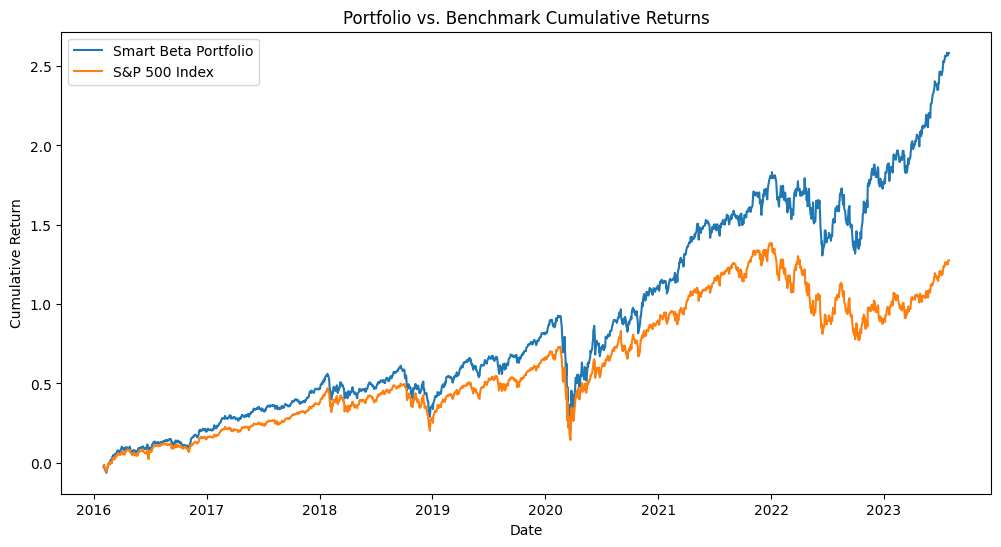

In [26]:
plt.figure(figsize=(12,6))
plt.plot(portfolio_cumulative_returns, label='Smart Beta Portfolio')
plt.plot(benchmark_cumulative_returns, label='S&P 500 Index')
plt.title('Portfolio vs. Benchmark Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


**Performance Metrics**

In [27]:
def calculate_performance_metrics(returns):
    # Annualized return
    cumulative_return = (1 + returns).prod() - 1
    num_years = (returns.index[-1] - returns.index[0]).days / 365.25
    annual_return = (1 + cumulative_return) ** (1 / num_years) - 1
    # Annualized volatility
    annual_volatility = returns.std() * np.sqrt(252)
    # Sharpe Ratio (Assuming risk-free rate is zero)
    sharpe_ratio = annual_return / annual_volatility
    return annual_return, annual_volatility, sharpe_ratio

annual_return, annual_volatility, sharpe_ratio = calculate_performance_metrics(benchmark_returns)

print(f'Benchmark Annual Return: {annual_return:.2%}')
print(f'Benchmark Volatility: {annual_volatility:.2%}')
print(f'Benchmark Sharpe Ratio: {sharpe_ratio:.2f}')


Benchmark Annual Return: 11.61%
Benchmark Volatility: 18.91%
Benchmark Sharpe Ratio: 0.61


In [28]:
pf_annual_return, pf_annual_volatility, pf_sharpe_ratio = calculate_performance_metrics(portfolio_returns)

print(f'Annual Return: {pf_annual_return:.2%}')
print(f'Annual Volatility: {pf_annual_volatility:.2%}')
print(f'Sharpe Ratio: {pf_sharpe_ratio:.2f}')

Annual Return: 18.57%
Annual Volatility: 19.39%
Sharpe Ratio: 0.96


### Rebalancing Policies
**Monthly Rebalancing**

In [29]:
rebalance_dates = monthly_prices.index[12:]  # Start after 12 months

**Transaction Cost Considerations**

Include transaction costs in the backtest.

In [30]:
transaction_cost = 0.0005  # 0.05% per trade
total_costs = 0
portfolio_returns_net = pd.Series(dtype=float)

prev_weights = None

for i in range(len(rebalance_dates)-1):
    start_date = rebalance_dates[i]
    end_date = rebalance_dates[i+1]
    weights = portfolio_weights

    if prev_weights is not None:
        # Calculate turnover
        turnover = (weights - prev_weights).abs().sum()
        costs = turnover * transaction_cost
    else:
        costs = 0

    total_costs += costs
    prev_weights = weights.copy()

    # Get period returns
    period_prices = data.loc[start_date:end_date, weights.index]
    period_returns = period_prices.pct_change().dropna()
    # Calculate portfolio returns
    returns = period_returns.mul(weights, axis=1).sum(axis=1) - costs
    if portfolio_returns_net.empty:
        portfolio_returns_net = returns
    else:
        portfolio_returns_net = pd.concat([portfolio_returns_net, returns])


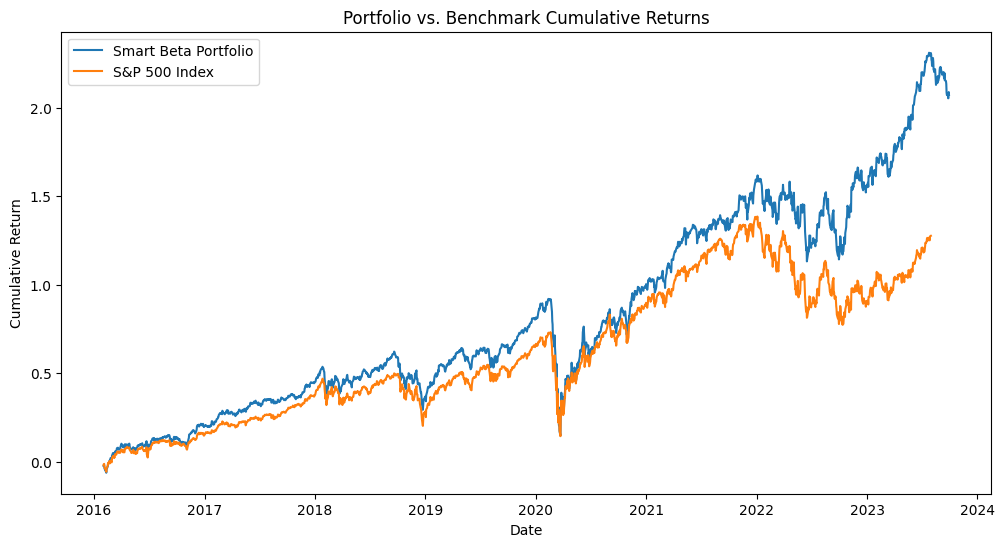

In [31]:
portfolio_cumulative_returns_net = (1 + portfolio_returns_net).cumprod() - 1
plt.figure(figsize=(12,6))
plt.plot(portfolio_cumulative_returns_net, label='Smart Beta Portfolio')
plt.plot(benchmark_cumulative_returns, label='S&P 500 Index')
plt.title('Portfolio vs. Benchmark Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [32]:
pf_annual_return, pf_annual_volatility, pf_sharpe_ratio = calculate_performance_metrics(portfolio_returns_net)

print(f'Portfolio Annual Return: {pf_annual_return:.2%}')
print(f'Portfolio Annual Volatility: {pf_annual_volatility:.2%}')
print(f'Portfolio Sharpe Ratio: {pf_sharpe_ratio:.2f}')

Portfolio Annual Return: 15.79%
Portfolio Annual Volatility: 19.21%
Portfolio Sharpe Ratio: 0.82


### Risk Management
**Maximum Drawdown**

In [33]:
def max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_dd = drawdown.min()
    return max_dd

max_dd = max_drawdown(portfolio_returns_net)
print(f'Maximum Drawdown: {max_dd:.2%}')


Maximum Drawdown: -40.23%


**Beta Exposure**

Calculate beta against a benchmark (e.g., S&P 500).

In [34]:
# Get benchmark returns
benchmark_data = yf.download('^GSPC', start='2015-01-01', end='2023-10-01', progress=False)['Adj Close']
benchmark_returns = benchmark_data.pct_change().loc[portfolio_returns_net.index]

# Align the data
aligned_returns = pd.concat([portfolio_returns_net, benchmark_returns], axis=1).dropna()
aligned_returns.columns = ['Portfolio', 'Benchmark']

# Calculate beta
covariance = aligned_returns.cov().iloc[0,1]
beta = covariance / aligned_returns['Benchmark'].var()
print(f'Portfolio Beta: {beta:.2f}')


Portfolio Beta: 0.97
